# Comparació de models d'optimització de carteres

Aquest codi proporciona  l'anàlisi, optimització i backtesting de carteres, utilitzant mètodes tradicionals de finances quantitatives (Markowitz) i tècniques d'aprenentatge automàtic (Random Forest i LSTM) per a la predicció de rendiments.

#### Importacions de Llibreries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

2025-05-27 17:43:06.072791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748360586.166760  881216 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748360586.185703  881216 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748360586.307108  881216 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748360586.307138  881216 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748360586.307141  881216 computation_placer.cc:177] computation placer alr

#### Llavor

In [2]:
def fixa_llavor(seed=42):
    """
    Fixa les llavors per a la reproductibilitat de resultats aleatoris en NumPy,
    Python i TensorFlow.
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
fixa_llavor()

#### Funcions Comunes

In [3]:
def portfolio_annualised_performance(weights: np.ndarray, mean_returns: pd.Series, cov_matrix: pd.DataFrame) -> tuple[float, float]:
    """
    Calcula el rendiment i la volatilitat anualitzats d'una cartera.
    """
    ret = np.sum(mean_returns * weights) * 252
    vol = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)
    return vol, ret

In [4]:
def random_portfolios(num_portfolios: int, mean_returns: pd.Series, cov_matrix: pd.DataFrame, risk_free_rate: float) -> tuple[np.ndarray, list]:
    """
    Genera carteres aleatòries per visualitzar la frontera eficient.
    """
    results = np.zeros((3, num_portfolios)) # Volatilitat, Rendiment, Sharpe
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights) # Normalitzar pesos perquè sumin 1
        weights_record.append(weights)

        vol, ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        sharpe = (ret - risk_free_rate) / vol if vol != 0 else 0
        
        results[0, i] = vol
        results[1, i] = ret
        results[2, i] = sharpe
    return results, weights_record

In [5]:
def plot_allocation_pie(allocation: pd.DataFrame, title: str):
    """
    Mostra un gràfic de pastís de la distribució de la cartera.
    """
    plt.figure(figsize=(6, 6))
    plt.pie(allocation['allocation'], labels=allocation.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal') # Manté el cercle perfecte
    plt.show()

In [6]:
def imprimir_resultats_cartera(title: str, allocation_df: pd.DataFrame, annual_return: float, annual_volatility: float):
    """
    Imprimeix i visualitza els resultats d'una cartera optimitzada.
    """
    print(f"\n--- {title} ---")
    print(f"Rendiment anualitzat: {annual_return:.4f}")
    print(f"Volatilitat anualitzada: {annual_volatility:.4f}")
    print(allocation_df.T) # Mostrem la transposta per millor visualització
    plot_allocation_pie(allocation_df, f"{title} - Distribució")

#### Funcions per a l'Optimització Numèrica de Markowitz 

In [7]:
def neg_sharpe_ratio(weights: np.ndarray, mean_returns: pd.Series, cov_matrix: pd.DataFrame, risk_free_rate: float) -> float:
    """
    Funció objectiu per maximitzar el Sharpe Ratio (negatiu per a minimització).
    """
    p_vol, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_vol if p_vol != 0 else np.inf

In [8]:
# Hem modificat la funció de volatilitat per rebre la matriu de covariàncies directament
def portfolio_volatility(weights: np.ndarray, cov_matrix: pd.DataFrame) -> float:
    """
    Funció objectiu per minimitzar la volatilitat de la cartera.
    """
    # portfolio_annualised_performance ja retorna (vol, ret)
    return np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)

In [9]:
# Hem modificat optimize_markowitz per acceptar un target_return_for_min_vol
def optimize_markowitz(mean_returns: pd.Series, cov_matrix: pd.DataFrame, risk_free_rate: float, asset_tickers: list, target_return_for_min_vol: float = None) -> tuple[pd.DataFrame, pd.DataFrame, tuple, tuple]:
    """
    Realitza l'optimització de Markowitz per trobar carteres de màxim Sharpe i mínima volatilitat.
    Retorna les distribucions de pesos i els punts (volatilitat, rendiment).
    
    Si target_return_for_min_vol és None, busca la cartera de mínima volatilitat global.
    Si s'especifica, busca la cartera de mínima volatilitat per al rendiment objectiu.
    """
    num_assets = len(asset_tickers)
    
    # Restriccions generals: la suma dels pesos ha de ser 1, i els pesos entre 0 i 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.array(num_assets * [1. / num_assets,])

    # 1. Optimitzar per al màxim Sharpe Ratio
    args_sharpe = (mean_returns, cov_matrix, risk_free_rate)
    opts = sco.minimize(neg_sharpe_ratio, initial_weights, args=args_sharpe, method='SLSQP', bounds=bounds, constraints=constraints)
    max_sharpe_weights = opts['x']

    # 2. Optimitzar per a la mínima volatilitat
    # Si target_return_for_min_vol és None, mantenim el comportament original de mínima volatilitat global
    if target_return_for_min_vol is None:
        args_vol = (cov_matrix,) # Només la matriu de covariàncies
        optv = sco.minimize(portfolio_volatility, initial_weights, args=args_vol, method='SLSQP', bounds=bounds, constraints=constraints)
    else:
        # Si target_return_for_min_vol s'ha definit, afegim una restricció per al rendiment
        # La restricció que el rendiment de la cartera sigui igual o superior al target
        constraints_min_vol = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}, # Suma dels pesos = 1
            {'type': 'eq', 'fun': lambda x: portfolio_annualised_performance(x, mean_returns, cov_matrix)[1] - target_return_for_min_vol} # Rendiment = target_return
        )
        args_vol = (cov_matrix,) # La funció portfolio_volatility encara només necessita la covariància
        optv = sco.minimize(portfolio_volatility, initial_weights, args=args_vol, method='SLSQP', bounds=bounds, constraints=constraints_min_vol)
        
    min_vol_weights = optv['x']

    # Formatar resultats
    max_sharpe_alloc = pd.DataFrame(max_sharpe_weights, index=asset_tickers, columns=["allocation"])
    max_sharpe_alloc["allocation"] = (max_sharpe_alloc["allocation"] * 100).round(2)
    max_sharpe_point = portfolio_annualised_performance(max_sharpe_weights, mean_returns, cov_matrix)

    min_vol_alloc = pd.DataFrame(min_vol_weights, index=asset_tickers, columns=["allocation"])
    min_vol_alloc["allocation"] = (min_vol_alloc["allocation"] * 100).round(2)
    min_vol_point = portfolio_annualised_performance(min_vol_weights, mean_returns, cov_matrix)

    return max_sharpe_alloc, min_vol_alloc, max_sharpe_point, min_vol_point


#### Funcions de Backtesting i Benchmarks 

In [10]:
def create_lstm_model(lookback_steps: int):
    """Crea i compila un model LSTM."""
    model = Sequential([
        Input(shape=(lookback_steps, 1)),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
def backtest_strategy(rendiments_df: pd.DataFrame, strategy_type: str, start_year: int = 2019, lookback: int = 60, risk_free_rate: float = 0.0385):
    """
    Backtesting anual per a Markowitz, RF i LSTM utilitzant optimització numèrica per la cartera.
    """
    anys = sorted(rendiments_df.index.year.unique())
    backtest_results = []

    # Ajustar l'any d'inici per assegurar que hi hagi dades d'entrenament abans del primer any de test
    if start_year not in anys:
        print(f"Warning: Start year {start_year} not found in data. Using the earliest available year for backtesting.")
        start_year = anys[0]

    for i in range(anys.index(start_year), len(anys) - 1):
        train_years = anys[:i+1]
        test_year = anys[i+1]

        rend_train = rendiments_df[rendiments_df.index.year.isin(train_years)]
        rend_test = rendiments_df[rendiments_df.index.year == test_year]

        if rend_test.empty:
            print(f"Skipping {strategy_type} for year {test_year}: No test data available.")
            continue

        mean_returns_pred = pd.Series() # Inicialitzar buit
        cov_matrix_train = rend_train.cov()

        # --- Entrenament i predicció de rendiments futurs ---
        if strategy_type == 'markowitz':
            mean_returns_pred = rend_train.mean()
        elif strategy_type == 'rf':
            X_train_rf_bt = rend_train.shift(1).dropna()
            y_train_rf_bt = rend_train.iloc[1:]

            if X_train_rf_bt.empty or y_train_rf_bt.empty:
                print(f"Skipping RF for year {test_year}: Not enough training data for RF.")
                continue

            # Utilitzem el millor model trobat prèviament o un de base
            model_to_use = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10, random_state=42)
            model_to_use.fit(X_train_rf_bt, y_train_rf_bt)
            
            # Predir el rendiment del proper pas de temps utilitzant l'última observació del tren
            last_input_train = rend_train.iloc[-1:].values
            pred = model_to_use.predict(last_input_train).flatten()
            mean_returns_pred = pd.Series(pred, index=rend_train.columns)

        elif strategy_type == 'lstm':
            temp_preds = []
            for ticker in rend_train.columns:
                serie_ticker = rend_train[ticker].dropna().values.reshape(-1, 1)

                if len(serie_ticker) < lookback + 1:
                    temp_preds.append(0.0)
                    continue

                scaler_bt = MinMaxScaler()
                serie_escala_bt = scaler_bt.fit_transform(serie_ticker)

                X_lstm_bt, y_lstm_bt = [], []
                for j in range(lookback, len(serie_escala_bt)):
                    X_lstm_bt.append(serie_escala_bt[j-lookback:j])
                    y_lstm_bt.append(serie_escala_bt[j])
                X_lstm_bt, y_lstm_bt = np.array(X_lstm_bt), np.array(y_lstm_bt)
                X_lstm_bt = X_lstm_bt.reshape((X_lstm_bt.shape[0], lookback, 1))

                if X_lstm_bt.shape[0] == 0:
                    temp_preds.append(0.0)
                    continue

                model_lstm_bt = create_lstm_model(lookback)
                model_lstm_bt.fit(X_lstm_bt, y_lstm_bt, epochs=50, batch_size=32, verbose=0)

                last_seq_lstm_bt = serie_escala_bt[-lookback:].reshape(1, lookback, 1)
                pred_scaled_bt = model_lstm_bt.predict(last_seq_lstm_bt, verbose=0)[0][0]
                pred_unscaled_bt = scaler_bt.inverse_transform(np.array([[pred_scaled_bt]]))[0][0]
                temp_preds.append(pred_unscaled_bt)
            mean_returns_pred = pd.Series(temp_preds, index=rend_train.columns)
        else:
            raise ValueError(f"Estratègia '{strategy_type}' no suportada.")

        # --- Construcció de la cartera utilitzant optimització numèrica ---
        # Filtrem els actius vàlids: els que tenen prediccions i estan en la matriu de covariància
        common_tickers = mean_returns_pred.index.intersection(cov_matrix_train.columns)
        mean_returns_filtered = mean_returns_pred[common_tickers]
        cov_matrix_filtered = cov_matrix_train.loc[common_tickers, common_tickers]

        if mean_returns_filtered.empty or cov_matrix_filtered.empty or len(common_tickers) < 2:
            print(f"Skipping optimization for year {test_year} with {strategy_type}: Not enough valid assets.")
            continue

        try:
            # Optimitza per al màxim Sharpe Ratio
            # Aquí, el backtesting sempre optimitzarà per al màxim Sharpe Ratio,
            # sense considerar la cartera de mínima volatilitat per la seva avaluació anual.
            # Si volguéssim avaluar la de mínima volatilitat en el backtest, caldria un altre `backtest_strategy`.
            
            # NOTA: Per al backtesting, normalment només avaluaríem una estratègia,
            # com la de màxim Sharpe o mínima volatilitat.
            # Aquí, estem construint la cartera de màxim Sharpe per al backtest.
            max_sharpe_alloc_bt, _, max_sharpe_point_bt, _ = optimize_markowitz(mean_returns_filtered, cov_matrix_filtered, risk_free_rate, common_tickers.tolist(), target_return_for_min_vol=None)
            weights = max_sharpe_alloc_bt["allocation"].values / 100 # Convertir percentatges a decimals

        except Exception as e:
            print(f"Error optimizing portfolio for year {test_year} with {strategy_type}: {e}. Skipping.")
            continue

        # --- Avaluació de la cartera amb rendiments reals de l'any de test ---
        rend_test_filtered = rend_test[common_tickers]

        if not rend_test_filtered.empty and len(weights) == len(common_tickers):
            daily_portfolio_returns = rend_test_filtered @ weights
            annual_real_return = daily_portfolio_returns.sum() # Suma de rendiments logarítmics
            annual_real_volatility = daily_portfolio_returns.std() * np.sqrt(252) # Volatilitat anualitzada
            real_sharpe = (annual_real_return - risk_free_rate) / annual_real_volatility if annual_real_volatility != 0 else 0
        else:
            annual_real_return = 0
            annual_real_volatility = 0
            real_sharpe = 0
            print(f"Warning: No real returns to evaluate for year {test_year} or weights mismatch for {strategy_type}.")

        backtest_results.append({
            "any": test_year,
            "rendiment_real": annual_real_return,
            "volatilitat_real": annual_real_volatility,
            "sharpe_real": real_sharpe,
            "pesos": weights.tolist()
        })

    return pd.DataFrame(backtest_results)


In [12]:
def benchmark_equal_weight(rendiments_df: pd.DataFrame, start_year: int = 2019, risk_free_rate: float = 0.0385) -> pd.DataFrame:
    """
    Calcula el rendiment d'una cartera amb pesos iguals com a benchmark.
    """
    anys = sorted(rendiments_df.index.year.unique())
    results = []

    for i in range(anys.index(start_year) + 1, len(anys)):
        test_year = anys[i]
        rend_test = rendiments_df[rendiments_df.index.year == test_year]

        if rend_test.empty:
            continue

        n_assets = rend_test.shape[1]
        if n_assets == 0: continue

        weights = np.array([1 / n_assets] * n_assets)

        daily_portfolio_returns = rend_test @ weights
        annual_real_return = daily_portfolio_returns.sum()
        annual_real_volatility = daily_portfolio_returns.std() * np.sqrt(252)
        real_sharpe = (annual_real_return - risk_free_rate) / annual_real_volatility if annual_real_volatility != 0 else 0

        results.append({
            "any": test_year,
            "rendiment_real": annual_real_return,
            "volatilitat_real": annual_real_volatility,
            "sharpe_real": real_sharpe
        })
    return pd.DataFrame(results)

In [13]:
def benchmark_buy_hold_average(rendiments_df: pd.DataFrame, start_year: int = 2019, risk_free_rate: float = 0.0385) -> pd.DataFrame:
    """
    Calcula el rendiment mitjà i altres mètriques d'una estratègia "Buy & Hold"
    (mitjana dels actius individuals) per a cada any de test.
    """
    anys = sorted(rendiments_df.index.year.unique())
    results = []

    for i in range(anys.index(start_year) + 1, len(anys)):
        test_year = anys[i]
        rend_test = rendiments_df[rendiments_df.index.year == test_year]

        if rend_test.empty:
            continue

        annual_returns = rend_test.sum()
        annual_volatilities = rend_test.std() * np.sqrt(252)
        sharpe_ratios = (annual_returns - risk_free_rate) / annual_volatilities.replace(0, np.nan) # Evitar div per zero

        results.append({
            "any": test_year,
            "rendiment_real": annual_returns.mean(),
            "volatilitat_real": annual_volatilities.mean(),
            "sharpe_real": sharpe_ratios.mean()
        })
    return pd.DataFrame(results)

#### Funcions Rànquing d'Actius 

In [14]:
def rank_assets(rendiments_df: pd.DataFrame, risk_free_rate: float = 0.0385) -> pd.DataFrame:
    """
    Calcula un rànquing d'actius basat en rendiment acumulat, volatilitat anualitzada i Sharpe ratio.
    """
    # Rendiment acumulat total (suma de log returns)
    cumulative_returns = rendiments_df.sum()

    # Volatilitat anualitzada per actiu
    annual_volatility = rendiments_df.std() * np.sqrt(252)

    # Sharpe ratio per actiu (evitar divisió per zero amb .replace(0, np.nan))
    sharpe_ratio = (cumulative_returns - risk_free_rate) / annual_volatility.replace(0, np.nan)

    df_ranking = pd.DataFrame({
        'Rendiment_acumulat': cumulative_returns,
        'Volatilitat_anual': annual_volatility,
        'Sharpe_ratio': sharpe_ratio
    })

    # Ordenar per Sharpe ratio de forma descendent per defecte
    df_ranking = df_ranking.sort_values(by='Sharpe_ratio', ascending=False)

    print("\n" + "="*60)
    print("                RÀNQUING D'ACTIUS (Sharpe Ratio)              ")
    print("="*60)
    print(df_ranking[['Sharpe_ratio', 'Rendiment_acumulat', 'Volatilitat_anual']].round(4)) # Mostrem només les columnes més rellevants

    return df_ranking

In [15]:
def plot_ranking_bars(df_ranking: pd.DataFrame, top_n: int = 10):
    """
    Mostra barres comparatives dels top N actius per rendiment acumulat i Sharpe ratio.
    """
    # Selecciona els top_n actius per rendiment i Sharpe
    top_cumulative_return = df_ranking['Rendiment_acumulat'].sort_values(ascending=False).head(top_n)
    top_sharpe = df_ranking['Sharpe_ratio'].sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(14, 6))

    # Barplot Rendiment acumulat
    plt.subplot(1, 2, 1)
    top_cumulative_return.plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} actius per Rendiment acumulat')
    plt.ylabel('Rendiment acumulat (log returns)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle=':', alpha=0.7)

    # Barplot Sharpe ratio
    plt.subplot(1, 2, 2)
    top_sharpe.plot(kind='bar', color='lightgreen')
    plt.title(f'Top {top_n} actius per Sharpe ratio')
    plt.ylabel('Sharpe ratio')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()


####  Càrrega i Preparació de Dades 

In [16]:
try:
    dades = pd.read_csv('dades_borses.csv', index_col=0, parse_dates=True)
except FileNotFoundError:
    print("Error: 'dades_borses.csv' no trobat. Assegura't que el fitxer és al mateix directori.")
    exit()

tickers = dades.columns.tolist() # Convertim a llista per consistència
tickers

['SAP.DE',
 'BAYN.DE',
 'BMW.DE',
 'ALV.DE',
 'DTE.DE',
 'VOW3.DE',
 'ADS.DE',
 'FRE.DE',
 'DBK.DE',
 'MUV2.DE']

In [17]:
def calcula_rendiments(dades_preus: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula els rendiments logarítmics diaris a partir de les dades de preus de tancament.
    """
    return np.log(dades_preus / dades_preus.shift(1)).dropna()

rendiments = calcula_rendiments(dades)
rendiments

,SAP.DE,BAYN.DE,BMW.DE,ALV.DE,DTE.DE,VOW3.DE,ADS.DE,FRE.DE,DBK.DE,MUV2.DE
Index,,,,,,,,,,
2019-01-03,-0.031523,-0.000986,-0.009943,-0.010570,0.007395,-0.011069,-0.002443,-0.046939,-0.007160,-0.006123
2019-01-04,0.024950,0.065258,0.037799,0.023965,0.007673,0.041570,0.037871,0.075252,0.046520,0.019043
2019-01-07,0.002080,-0.015998,0.005701,-0.008152,0.001328,0.001138,-0.007091,-0.011092,0.015347,-0.012920
2019-01-08,0.015465,0.025506,0.001247,0.001023,-0.013365,0.016641,0.023960,-0.024658,0.009490,-0.011209
2019-01-09,0.013661,0.001068,0.010196,0.005888,-0.006411,0.024044,-0.002319,0.011368,-0.028070,0.007220
...,...,...,...,...,...,...,...,...,...,...
2023-12-21,-0.011706,0.001841,-0.008701,-0.002480,-0.000692,-0.011142,-0.007788,0.002804,-0.000976,-0.004736
2023-12-22,0.004786,0.002756,0.010890,0.003924,0.005756,0.000889,-0.054324,0.001399,0.007785,0.007357
2023-12-27,0.011508,0.022972,-0.002388,-0.003717,-0.005987,0.002130,0.007682,-0.008424,0.001614,-0.009205


#### Anàlisi de Correlació 

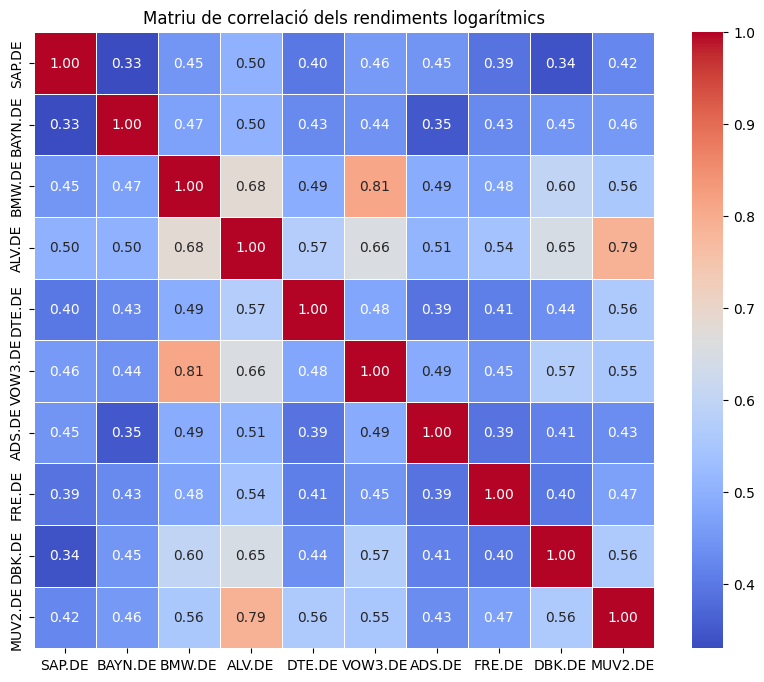

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(rendiments.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriu de correlació dels rendiments logarítmics")
plt.show()

#### Paràmetres Globals de Cartera

In [19]:
RISK_FREE_RATE = 0.0385 # Taxa lliure de risc
NUM_PORTFOLIOS_SIMULATION = 5000 # Nombre de carteres per a la simulació (visualització de la frontera)
TARGET_RETURN_PERCENTAGE_FOR_MIN_VOL = 0.5 # Percentatge del rendiment del Màxim Sharpe per al target de Mínima Volatilitat

#### Model 1: Markowitz Tradicional

In [20]:
# print("\n--- 1. Processant Model de Markowitz Tradicional ---")
mean_returns_mk = rendiments.mean()
cov_matrix_mk = rendiments.cov()

In [21]:
# Realitzem l'optimització numèrica per Markowitz
# Per la mínima volatilitat Markowitz, podem usar un target que sigui un percentatge del seu propi màxim Sharpe
# Primer, obtenir el màxim Sharpe sense un target explícit per la mínima volatilitat
max_alloc_mk_temp, _, max_point_mk_temp, _ = optimize_markowitz(mean_returns_mk, cov_matrix_mk, RISK_FREE_RATE, tickers, target_return_for_min_vol=None)
target_return_mk = max_point_mk_temp[1] * TARGET_RETURN_PERCENTAGE_FOR_MIN_VOL

In [22]:
# Ara, optimitzar amb el target de rendiment per a la mínima volatilitat
max_alloc_mk, min_alloc_mk, max_point_mk, min_point_mk = optimize_markowitz(mean_returns_mk, cov_matrix_mk, RISK_FREE_RATE, tickers, target_return_for_min_vol=target_return_mk)

In [23]:
# Opcional: Simulació per a la visualització de la frontera
results_mk, weights_mk = random_portfolios(NUM_PORTFOLIOS_SIMULATION, mean_returns_mk, cov_matrix_mk, RISK_FREE_RATE)

#### Model 2: Random Forest (RF) 

In [24]:
# Les dades per a RF han de ser "features" (X) i "target" (y)
# X: rendiments passats (shift 1)
# y: rendiments actuals
X_rf = rendiments.shift(1).dropna()
y_rf = rendiments.iloc[1:] # Els rendiments actuals corresponen a X_rf

In [25]:
# Dividir dades per a entrenament i test. Shuffle=False per mantenir l'ordre temporal.
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, shuffle=False, test_size=0.2)

In [26]:
# Paràmetres per GridSearchCV
param_grid_rf = {
    'max_depth': [5, 10, 15], # Reduït per a proves ràpides
    'min_samples_split': [2, 5, 10]
}

rf_base = RandomForestRegressor(n_estimators=100, random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid_rf, cv=5, 
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_rf, y_train_rf)

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

print(f"\nMillors hiperparàmetres per Random Forest: {best_params_rf}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Millors hiperparàmetres per Random Forest: {'max_depth': 5, 'min_samples_split': 10}


In [27]:
y_pred_rf = best_model_rf.predict(X_test_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
print(f"MSE Random Forest (amb GridSearchCV): {mse_rf:.6f}")

MSE Random Forest (amb GridSearchCV): 0.000258


In [28]:
# Predicció dels "rendiments futurs" per a l'optimització de cartera
last_input_rf = rendiments.iloc[-1:].values
future_returns_rf = best_model_rf.predict(last_input_rf).flatten()
mean_returns_rf = pd.Series(future_returns_rf, index=tickers)

/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [29]:
# Optimització de cartera amb les prediccions de RF
# Primer, obtenir el màxim Sharpe per definir el target per la mínima volatilitat
max_alloc_rf_temp, _, max_point_rf_temp, _ = optimize_markowitz(mean_returns_rf, cov_matrix_mk, RISK_FREE_RATE, tickers, target_return_for_min_vol=None)
target_return_rf = max_point_rf_temp[1] * TARGET_RETURN_PERCENTAGE_FOR_MIN_VOL

In [30]:
# Ara, optimitzar amb el target de rendiment per a la mínima volatilitat
max_alloc_rf, min_alloc_rf, max_point_rf, min_point_rf = optimize_markowitz(mean_returns_rf, cov_matrix_mk, RISK_FREE_RATE, tickers, target_return_for_min_vol=target_return_rf)


In [31]:
# Opcional: Simulació per a la visualització de la frontera de RF
results_rf_sim, weights_rf_sim = random_portfolios(NUM_PORTFOLIOS_SIMULATION, mean_returns_rf, cov_matrix_mk, RISK_FREE_RATE)

#### Model 3: Long Short-Term Memory (LSTM) 

In [32]:
LOOKBACK_LSTM = 60 # Nombre de passos temporals enrere per a cada seqüència
scaler_lstm = MinMaxScaler()
prediccions_lstm_futur = {} # Per a la predicció que Markowitz utilitzarà
mse_lstm_per_ticker = {} # Per avaluar el model per a cada ticker

In [33]:
for ticker in tickers:
    serie = rendiments[ticker].dropna().values.reshape(-1, 1)

    if len(serie) < LOOKBACK_LSTM + 1:
        print(f"Skipping {ticker}: Not enough data for lookback period ({len(serie)} data points, need at least {LOOKBACK_LSTM + 1}).")
        prediccions_lstm_futur[ticker] = 0.0 # Valor per defecte si no hi ha prou dades
        continue

    # Escalar la sèrie
    serie_escala = scaler_lstm.fit_transform(serie)

    # Crear seqüències per a l'entrenament i avaluació de LSTM
    X_lstm_seq, y_lstm_seq = [], []
    for i in range(LOOKBACK_LSTM, len(serie_escala)):
        X_lstm_seq.append(serie_escala[i-LOOKBACK_LSTM:i])
        y_lstm_seq.append(serie_escala[i])
    X_lstm_seq, y_lstm_seq = np.array(X_lstm_seq), np.array(y_lstm_seq)
    # Reshape per a LSTM: (mostres, timesteps, features)
    X_lstm_seq = X_lstm_seq.reshape((X_lstm_seq.shape[0], LOOKBACK_LSTM, 1))

    # Dividir les dades en entrenament i prova (mantenint l'ordre temporal)
    train_size_lstm = int(len(X_lstm_seq) * 0.8)
    X_train_lstm, X_test_lstm = X_lstm_seq[:train_size_lstm], X_lstm_seq[train_size_lstm:]
    y_train_lstm, y_test_lstm = y_lstm_seq[:train_size_lstm], y_lstm_seq[train_size_lstm:]

    if len(X_test_lstm) == 0:
        print(f"Skipping {ticker}: Test set is empty after splitting for LSTM.")
        prediccions_lstm_futur[ticker] = 0.0
        continue

    # Construcció del model LSTM
    model_lstm = Sequential([
        Input(shape=(LOOKBACK_LSTM, 1)), # Especificar la capa d'entrada amb Input
        LSTM(50, return_sequences=True), # return_sequences=True per apilar LSTMs
        Dropout(0.2),
        LSTM(50), # return_sequences=False per a l'última capa LSTM
        Dropout(0.2),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    early_stop_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Entrenament del model amb dades de validació
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, verbose=0,
                   callbacks=[early_stop_lstm], validation_split=0.2)

    # Fer prediccions sobre el CONJUNT DE PROVA per avaluar el MSE
    y_pred_lstm_eval = model_lstm.predict(X_test_lstm, verbose=0)

    # Invertir l'escalat de les prediccions i els valors reals de prova
    y_pred_lstm_unscaled = scaler_lstm.inverse_transform(y_pred_lstm_eval)
    y_test_lstm_unscaled = scaler_lstm.inverse_transform(y_test_lstm)

    # Calcular el MSE explícitament per al ticker actual
    mse_ticker_lstm = mean_squared_error(y_test_lstm_unscaled, y_pred_lstm_unscaled)
    mse_lstm_per_ticker[ticker] = mse_ticker_lstm
    print(f"MSE LSTM per {ticker}: {mse_ticker_lstm:.6f}")

    # Realitzar la predicció per a la optimització de la cartera (última seqüència de dades)
    ultima_seq_lstm = serie_escala[-LOOKBACK_LSTM:].reshape(1, LOOKBACK_LSTM, 1)
    prediccio_escala_futur = model_lstm.predict(ultima_seq_lstm, verbose=0)[0][0]
    prediccio_valor_futur = scaler_lstm.inverse_transform(np.array([[prediccio_escala_futur]]))[0][0]
    prediccions_lstm_futur[ticker] = prediccio_valor_futur

average_mse_lstm = np.mean(list(mse_lstm_per_ticker.values()))
print(f"\nMitjana del MSE LSTM per a tots els tickers: {average_mse_lstm:.6f}")

2025-05-27 17:43:43.471687: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


MSE LSTM per SAP.DE: 0.000148
MSE LSTM per BAYN.DE: 0.000365
MSE LSTM per BMW.DE: 0.000177
MSE LSTM per ALV.DE: 0.000117
MSE LSTM per DTE.DE: 0.000110
MSE LSTM per VOW3.DE: 0.000223
MSE LSTM per ADS.DE: 0.000456
MSE LSTM per FRE.DE: 0.000286
MSE LSTM per DBK.DE: 0.000402
MSE LSTM per MUV2.DE: 0.000131

Mitjana del MSE LSTM per a tots els tickers: 0.000242


In [34]:
# Convertir les prediccions futures en una Sèrie de Pandas amb els tickers com a índex
mean_returns_lstm = pd.Series(prediccions_lstm_futur)

In [35]:
# Optimització de cartera amb les prediccions de LSTM
# Primer, obtenir el màxim Sharpe per definir el target per la mínima volatilitat
max_alloc_lstm_temp, _, max_point_lstm_temp, _ = optimize_markowitz(mean_returns_lstm, cov_matrix_mk, RISK_FREE_RATE, tickers, target_return_for_min_vol=None)
target_return_lstm = max_point_lstm_temp[1] * TARGET_RETURN_PERCENTAGE_FOR_MIN_VOL

In [36]:
# Ara, optimitzar amb el target de rendiment per a la mínima volatilitat
max_alloc_lstm, min_alloc_lstm, max_point_lstm, min_point_lstm = optimize_markowitz(mean_returns_lstm, cov_matrix_mk, RISK_FREE_RATE, tickers, target_return_for_min_vol=target_return_lstm)

In [37]:
# Opcional: Simulació per a la visualització de la frontera de LSTM
results_lstm_sim, weights_lstm_sim = random_portfolios(NUM_PORTFOLIOS_SIMULATION, mean_returns_lstm, cov_matrix_mk, RISK_FREE_RATE)

#### Resultats de les Carteres Òptimes


             RESUM DE RESULTATS DE CARTERES ÒPTIMES             

--- Cartera Màxim Sharpe (Markowitz Tradicional) ---
Rendiment anualitzat: 0.1621
Volatilitat anualitzada: 0.2462
            SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation    9.46      0.0    4.41     0.0   10.53      0.0     0.0     0.0   

            DBK.DE  MUV2.DE  
allocation     0.0     75.6  


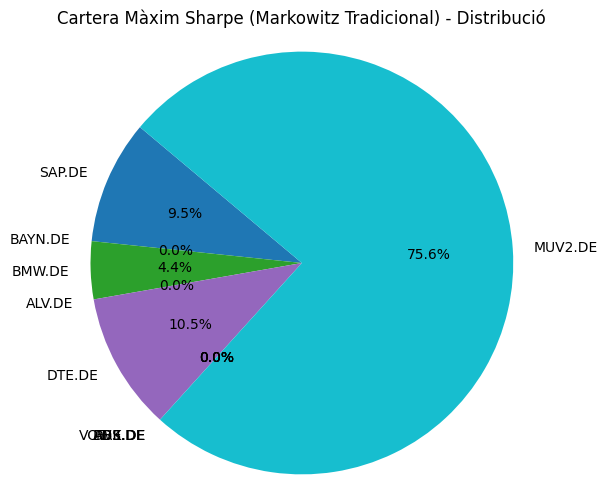


--- Cartera Mínima Volatilitat (Markowitz Tradicional) ---
Rendiment anualitzat: 0.0811
Volatilitat anualitzada: 0.1890
            SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation   19.35     5.67     0.0    4.42   57.84      0.0    0.26   10.35   

            DBK.DE  MUV2.DE  
allocation     0.0      2.1  


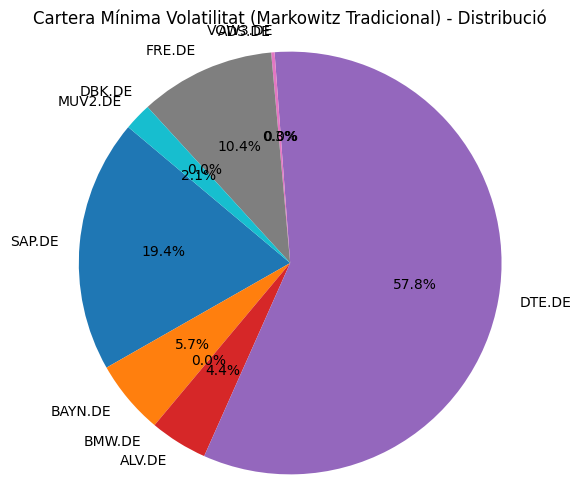


--- Cartera Màxim Sharpe (Random Forest) ---
Rendiment anualitzat: 0.3437
Volatilitat anualitzada: 0.2637
            SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation     0.0      0.0   18.38     0.0    4.44      0.0     0.0     0.0   

            DBK.DE  MUV2.DE  
allocation   19.97    57.22  


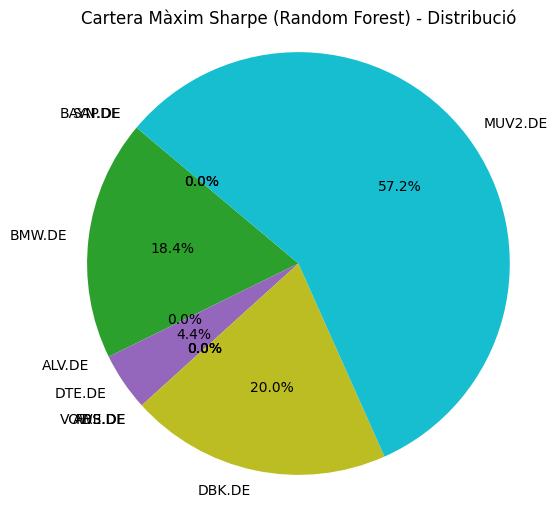


--- Cartera Mínima Volatilitat (Random Forest) ---
Rendiment anualitzat: 0.1718
Volatilitat anualitzada: 0.1890
            SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation   19.03     6.51     0.0    4.06   57.58      0.0    0.84   11.58   

            DBK.DE  MUV2.DE  
allocation     0.0     0.41  


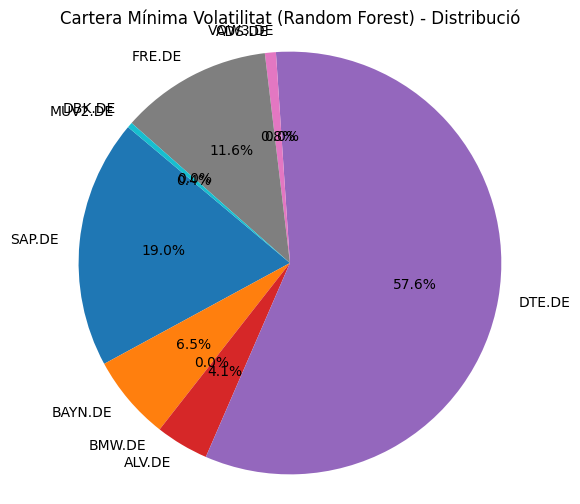


--- Cartera Màxim Sharpe (LSTM) ---
Rendiment anualitzat: 0.4086
Volatilitat anualitzada: 0.2692
            SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation     0.0    34.71   65.29     0.0     0.0      0.0     0.0     0.0   

            DBK.DE  MUV2.DE  
allocation     0.0      0.0  


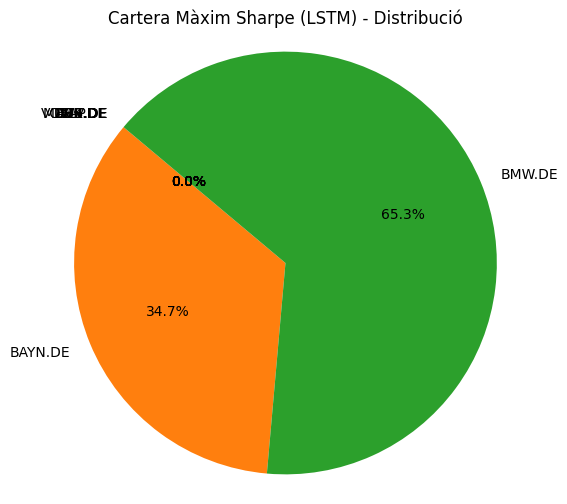


--- Cartera Mínima Volatilitat (LSTM) ---
Rendiment anualitzat: 0.2043
Volatilitat anualitzada: 0.1934
            SAP.DE  BAYN.DE  BMW.DE  ALV.DE  DTE.DE  VOW3.DE  ADS.DE  FRE.DE  \
allocation   14.64    12.86   11.76     0.0   60.33      0.0     0.0     0.0   

            DBK.DE  MUV2.DE  
allocation     0.0     0.41  


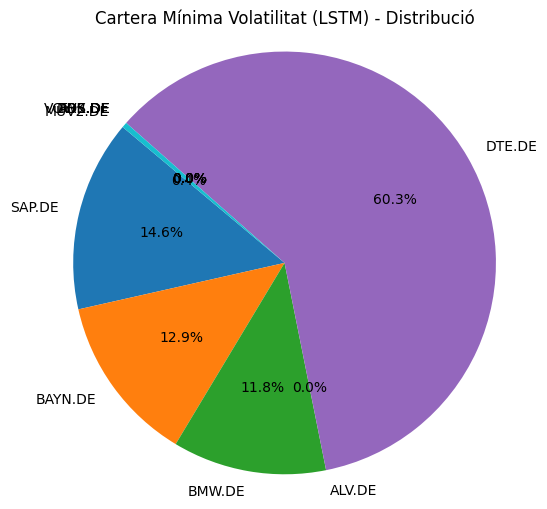

In [38]:
print("\n" + "="*60)
print("             RESUM DE RESULTATS DE CARTERES ÒPTIMES             ")
print("="*60)

imprimir_resultats_cartera("Cartera Màxim Sharpe (Markowitz Tradicional)", max_alloc_mk, max_point_mk[1], max_point_mk[0])
imprimir_resultats_cartera("Cartera Mínima Volatilitat (Markowitz Tradicional)", min_alloc_mk, min_point_mk[1], min_point_mk[0])

imprimir_resultats_cartera("Cartera Màxim Sharpe (Random Forest)", max_alloc_rf, max_point_rf[1], max_point_rf[0])
imprimir_resultats_cartera("Cartera Mínima Volatilitat (Random Forest)", min_alloc_rf, min_point_rf[1], min_point_rf[0]) # Aquesta línia ha estat corregida

imprimir_resultats_cartera("Cartera Màxim Sharpe (LSTM)", max_alloc_lstm, max_point_lstm[1], max_point_lstm[0])
imprimir_resultats_cartera("Cartera Mínima Volatilitat (LSTM)", min_alloc_lstm, min_point_lstm[1], min_point_lstm[0])


#### Execució de Backtesting i Comparació

In [39]:
# Executa backtest per a cada estratègia
bt_markowitz_opt = backtest_strategy(rendiments, strategy_type='markowitz', risk_free_rate=RISK_FREE_RATE)
bt_rf_opt = backtest_strategy(rendiments, strategy_type='rf', risk_free_rate=RISK_FREE_RATE)
bt_lstm_opt = backtest_strategy(rendiments, strategy_type='lstm', lookback=LOOKBACK_LSTM, risk_free_rate=RISK_FREE_RATE)

/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/maria/Documents/Uni/TFG/Codi/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [40]:
# Executa benchmarks
bt_benchmark_equal = benchmark_equal_weight(rendiments, risk_free_rate=RISK_FREE_RATE)
bt_benchmark_bh_avg = benchmark_buy_hold_average(rendiments, risk_free_rate=RISK_FREE_RATE)

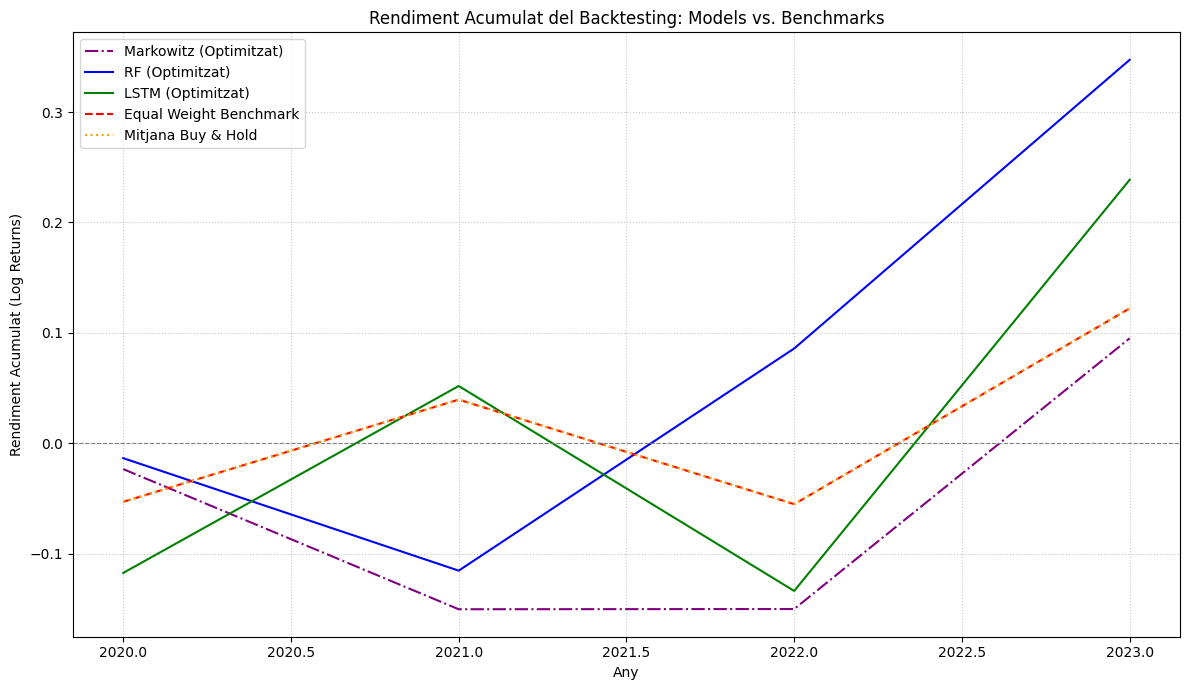

In [41]:
# --- Gràfic Comparatiu de Rendiments Acumulats ---
plt.figure(figsize=(12, 7))
plt.plot(bt_markowitz_opt["any"], bt_markowitz_opt["rendiment_real"].cumsum(), label='Markowitz (Optimitzat)', color='purple', linestyle='-.')
plt.plot(bt_rf_opt["any"], bt_rf_opt["rendiment_real"].cumsum(), label='RF (Optimitzat)', color='blue')
plt.plot(bt_lstm_opt["any"], bt_lstm_opt["rendiment_real"].cumsum(), label='LSTM (Optimitzat)', color='green')
plt.plot(bt_benchmark_equal["any"], bt_benchmark_equal["rendiment_real"].cumsum(), label='Equal Weight Benchmark', color='red', linestyle='--')
plt.plot(bt_benchmark_bh_avg["any"], bt_benchmark_bh_avg["rendiment_real"].cumsum(), label='Mitjana Buy & Hold', color='orange', linestyle=':')

plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.title("Rendiment Acumulat del Backtesting: Models vs. Benchmarks")
plt.xlabel("Any")
plt.ylabel("Rendiment Acumulat (Log Returns)")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

#### Rànquing d'Actius 


                RÀNQUING D'ACTIUS (Sharpe Ratio)              
         Sharpe_ratio  Rendiment_acumulat  Volatilitat_anual
MUV2.DE        3.0566              0.8968             0.2808
DTE.DE         2.3802              0.5331             0.2078
BMW.DE         2.0977              0.6752             0.3035
ALV.DE         2.0868              0.5785             0.2587
SAP.DE         1.9057              0.5696             0.2787
DBK.DE         1.3819              0.6180             0.4194
VOW3.DE        0.5711              0.2462             0.3636
ADS.DE         0.0191              0.0454             0.3590
FRE.DE        -1.1717             -0.3100             0.2974
BAYN.DE       -1.3348             -0.3903             0.3213


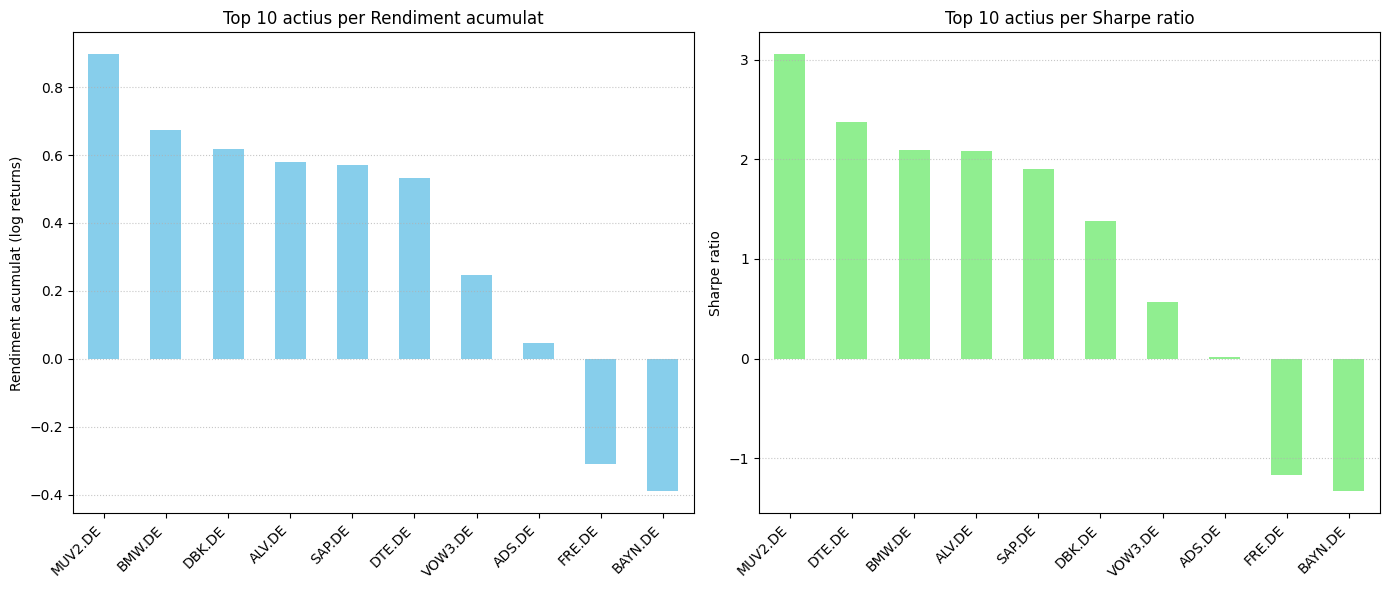

In [42]:
# Generar i visualitzar el rànquing
asset_ranking = rank_assets(rendiments, risk_free_rate=RISK_FREE_RATE)
plot_ranking_bars(asset_ranking, top_n=10)